# 

# Scikit-Learn

<span style="color:red">Noms des partenaires :</span>

1.   WAHARTE, Mathieu

2.   X, X

3.   X, X

## Exploration de données et classification

https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset

In [1]:
import platform

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import (
    datasets,
    decomposition,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
)

In [2]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

print(pd.__version__)       # 1.5.3
print(sklearn.__version__)  # 1.2.2

1.5.3
1.2.2


---

### Exploration avec pandas

#### Créez la dataframe

https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset


Descripteurs (features) :

* `age`: Age en années
* `sex`
* `bmi`: Indice de masse corporelle (IMC)
* `bp`: Tension artérielle moyenne
* `s1`: TC, cholestérol sérique total
* `s2`: LDL, lipoprotéines de basse densité
* `s3`: HDL, lipoprotéines de haute densité
* `s4`: TCH, cholestérol total / HDL
* `s5`: LTG, éventuellement logarithme du taux de triglycérides sériques
* `s6`: GLO, taux de sucre dans le sang


Cible (target) :

* Mesure quantitative de la progression de la maladie un an après la mesure de départ

In [3]:
diabetes = datasets.load_diabetes()

In [4]:
diab_df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
diab_df["target"] = diabetes.target
# df.describe()
diab_df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


#### Descriptions

In [5]:
diab_df.describe().style.format("{:.3g}")

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442,442,442,442,442,442,442,442,442,442,442
mean,-2.51e-19,1.23e-17,-2.25e-16,-4.8e-17,-1.38e-17,3.92e-17,-5.78e-18,-9.04e-18,9.29e-17,1.13e-17,152
std,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,77.1
min,-0.107,-0.0446,-0.0903,-0.112,-0.127,-0.116,-0.102,-0.0764,-0.126,-0.138,25
25%,-0.0373,-0.0446,-0.0342,-0.0367,-0.0342,-0.0304,-0.0351,-0.0395,-0.0332,-0.0332,87
50%,0.00538,-0.0446,-0.00728,-0.00567,-0.00432,-0.00382,-0.00658,-0.00259,-0.00195,-0.00108,140
75%,0.0381,0.0507,0.0312,0.0356,0.0284,0.0298,0.0293,0.0343,0.0324,0.0279,212
max,0.111,0.0507,0.171,0.132,0.154,0.199,0.181,0.185,0.134,0.136,346


#### Corrélations

On peut produire très rapidement un tableau des corrélations avec toutes les données via [`pandas.DataFrame.corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html).

In [6]:
corr_df = diab_df.corr()

corr_df.style.format("{:.2g}")

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,1,0.17,0.19,0.34,0.26,0.22,-0.075,0.2,0.27,0.3,0.19
sex,0.17,1,0.088,0.24,0.035,0.14,-0.38,0.33,0.15,0.21,0.043
bmi,0.19,0.088,1,0.4,0.25,0.26,-0.37,0.41,0.45,0.39,0.59
bp,0.34,0.24,0.4,1,0.24,0.19,-0.18,0.26,0.39,0.39,0.44
s1,0.26,0.035,0.25,0.24,1,0.9,0.052,0.54,0.52,0.33,0.21
s2,0.22,0.14,0.26,0.19,0.9,1,-0.2,0.66,0.32,0.29,0.17
s3,-0.075,-0.38,-0.37,-0.18,0.052,-0.2,1,-0.74,-0.4,-0.27,-0.39
s4,0.2,0.33,0.41,0.26,0.54,0.66,-0.74,1,0.62,0.42,0.43
s5,0.27,0.15,0.45,0.39,0.52,0.32,-0.4,0.62,1,0.46,0.57
s6,0.3,0.21,0.39,0.39,0.33,0.29,-0.27,0.42,0.46,1,0.38


La methode [`DataFrame.style.Styler.background_gradient`](https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.background_gradient.html) permet de représenter le `DataFrame` en *heatmap*.

Dans ce cas, il est important de prendre une double coloration (ici positive en vert et négative en rose) pour mettre en évidence à la fois la valeur absolue des corrélations et leur polarité.

In [7]:
corr_df.style.background_gradient(cmap="PiYG", vmin=-1).format("{:.2g}")

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,1,0.17,0.19,0.34,0.26,0.22,-0.075,0.2,0.27,0.3,0.19
sex,0.17,1,0.088,0.24,0.035,0.14,-0.38,0.33,0.15,0.21,0.043
bmi,0.19,0.088,1,0.4,0.25,0.26,-0.37,0.41,0.45,0.39,0.59
bp,0.34,0.24,0.4,1,0.24,0.19,-0.18,0.26,0.39,0.39,0.44
s1,0.26,0.035,0.25,0.24,1,0.9,0.052,0.54,0.52,0.33,0.21
s2,0.22,0.14,0.26,0.19,0.9,1,-0.2,0.66,0.32,0.29,0.17
s3,-0.075,-0.38,-0.37,-0.18,0.052,-0.2,1,-0.74,-0.4,-0.27,-0.39
s4,0.2,0.33,0.41,0.26,0.54,0.66,-0.74,1,0.62,0.42,0.43
s5,0.27,0.15,0.45,0.39,0.52,0.32,-0.4,0.62,1,0.46,0.57
s6,0.3,0.21,0.39,0.39,0.33,0.29,-0.27,0.42,0.46,1,0.38


#### Graphiques dans pandas

Il est possible de construire des graphiques très facilement à partir des `DataFrame` de pandas qui offrent un accès à l'API de Matplotlib, comme par exemple avec la méthode [`DataFrame.hist`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html).

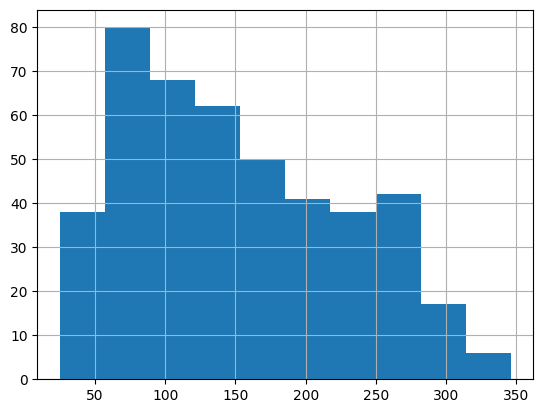

In [8]:
diab_df.target.hist()
plt.show()

Par défaut, l'histogramme est divisé en 10 paniers (*bins*). On peut voir que le choix du nombre de paniers influence grandement la forme des histogrammes.

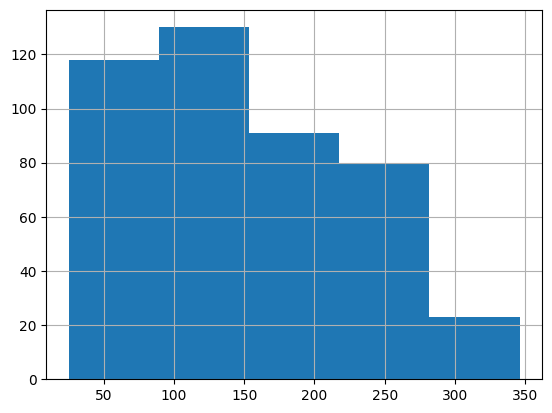

In [9]:
diab_df.target.hist(bins=5)
plt.show()

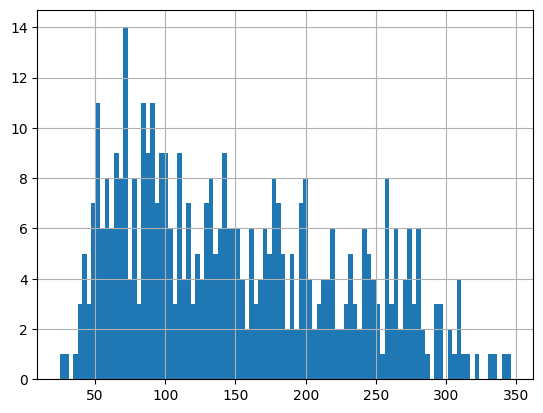

In [10]:
diab_df.target.hist(bins=100)
plt.show()

#### Scatter matrix

Une autre façon de visualiser la corrélation entre des descripteurs est via la fonction [`pandas.plotting.scatter_matrix`](https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html) de pandas. 

Comme on a 10 descripteurs numériques, vous obtiendrez $10 \times 10 = 100$ figures, ce qui ne serait pas lisible sur une page, alors concentrons-nous simplement sur quelques-uns d'entre eux.

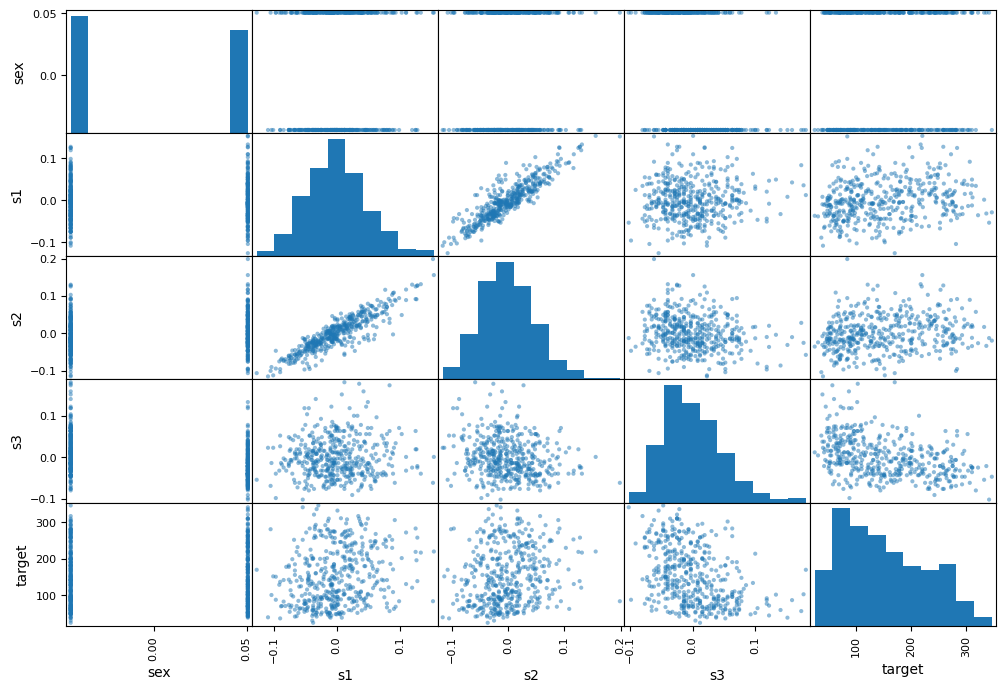

In [11]:
FTS = ["sex", "s1", "s2", "s3", "target"]
pd.plotting.scatter_matrix(diab_df[FTS], figsize=(12, 8))
plt.show()

On peut voir les corrélations positives et très forte entre `s1` et `s2`, et celles peu corrélées (en l'occurence `s2` et `s3`). 
On peut aussi observer que les corrélations de variables continues et binaires (`sex`) sont plus difficiles à interpréter.

---

### Classification (digits)

On va regarder la classification en terme de précision et rappel (et non-plus uniquement en terme d'accuracy).

#### Chargement des données

https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset

In [12]:
digits = datasets.load_digits()

In [13]:
# Flatten the images
n_samples = len(digits.images)
print(digits.images.shape)

data = digits.images.reshape([n_samples, -1])

print(data.shape, digits.target.shape)

(1797, 8, 8)
(1797, 64) (1797,)


Sélectionnez de manière aléatoire le dataset d'entrainement et de test (via la fonction [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)).

<span style="color:red">Implémentez votre solution ci-dessous</span>

In [14]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    data, digits.target, test_size=0.2, random_state=42
)

#### Entrainement des modèles

Entrainez le modèle avec l'algorithme de classification [Naive Bayes avec le noyau Gaussien](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html).

<span style="color:red">Implémentez votre solution ci-dessous</span>

In [15]:
gnb = naive_bayes.GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)

#### Évaluation

Évaluez avec l'[`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

Puis donnez une résultats plus complet, incluant précision, rappel est et f1-score avec la fonction [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

<span style="color:red">Implémentez votre solution ci-dessous</span>

In [16]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred),"\n")
print(metrics.classification_report(y_test, y_pred,target_names=diabetes.feature_names))

Accuracy: 0.8472222222222222 

              precision    recall  f1-score   support

         age       1.00      0.94      0.97        33
         sex       0.83      0.86      0.84        28
         bmi       0.91      0.61      0.73        33
          bp       0.91      0.85      0.88        34
          s1       0.97      0.83      0.89        46
          s2       0.90      0.94      0.92        47
          s3       0.92      0.97      0.94        35
          s4       0.69      0.97      0.80        34
          s5       0.57      0.87      0.68        30
          s6       0.96      0.65      0.78        40

    accuracy                           0.85       360
   macro avg       0.86      0.85      0.84       360
weighted avg       0.88      0.85      0.85       360



#### Matrice de confusion

Utiliser la class de scikit-learn [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions)
pour afficher la matrice de confusion.

Commentez succinctement les résultats.

Notez que l'attribut `.confusion_matrix` de l'objet retourné par la fonction permet d'obtenir la matrice de confusion sous forme d'array.

<span style="color:red">Implémentez votre solution ci-dessous</span>

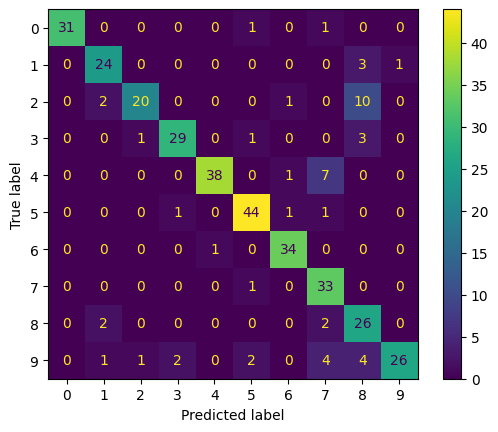

In [17]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
# on remarque que la corrélation entre modèle et réel est forte au vu de la diagonale dominante, il reste cepandant des erreurs de classification assez localisées

#### Visualisation des erreurs

Identifiez les cas les plus confus.

Identifiez les instances mal classées pour la classe de chiffre au f1-score le plus faible et visualisez les avec le code ci-dessous.

Vous pouvez utiliser la fonction [numpy.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html) pour trouver l'index des instances en question.

<span style="color:red">Implémentez votre solution ci-dessous</span>

In [18]:
# les cas les plus confus sont (2,8) et (4,7) avec aussi une augmentation locale de la confusion => les lignes 2 et 8 (bmi et s5) on en effet des f1-score de .73 et .68 resp., scores les plus faibles

np.where([y_test==2,y_test==8])

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([  4,   7,   9,  15,  63,  82,  91,  95, 109, 116, 120, 126, 138,
        161, 173, 178, 179, 185, 186, 195, 220, 229, 245, 252, 253, 254,
        293, 300, 309, 320, 322, 342, 349,  18,  19,  84,  92, 118, 129,
        139, 171, 182, 199, 204, 207, 215, 239, 240, 246, 247, 257, 258,
        289, 296, 323, 328, 329, 332, 335, 338, 346, 353, 357]))

---

### PCA

Utilisez une compression des dimensions par ACP ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)), en utilisant 10 composantes principales.

#### Initialisation des PCA et sélection des données entrainement/test

<span style="color:red">Implémentez votre solution ci-dessous</span>

In [19]:
N_COMP = 10
pca = decomposition.PCA(n_components=N_COMP)
pca.fit(x_train)

PCA(n_components=10)

#### Entrainement des modèles

In [20]:
gnb.fit(pca.transform(x_train), y_train)
y_pred_pca = gnb.predict(pca.transform(x_test))

#### Évaluation

<span style="color:red">Implémentez votre solution ci-dessous</span>

              precision    recall  f1-score   support

         age       1.00      0.91      0.95        33
         sex       0.69      0.89      0.78        28
         bmi       1.00      0.97      0.98        33
          bp       0.97      0.91      0.94        34
          s1       0.98      0.98      0.98        46
          s2       0.93      0.89      0.91        47
          s3       1.00      0.97      0.99        35
          s4       0.91      0.91      0.91        34
          s5       0.89      0.83      0.86        30
          s6       0.79      0.85      0.82        40

    accuracy                           0.91       360
   macro avg       0.92      0.91      0.91       360
weighted avg       0.92      0.91      0.92       360



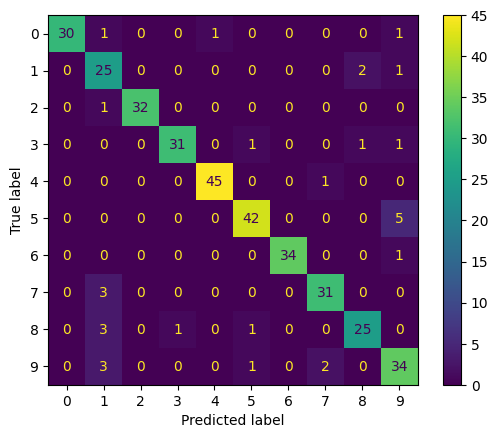

In [21]:
print(metrics.classification_report(y_test, y_pred_pca,target_names=diabetes.feature_names))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pca)
plt.show()

---

### Cross-Validation

![](img/grid_search_cross_validation.png)

#### Chargement des données

Utilisez la fonction [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) pour implémenter la cross-validation.

Vous choisirez de faire 10 splits (`cv=10`).

Choisissez comme *scoring* `"f1_weighted"`, la fonction retournera alors les scores correspondants dans une array.

À titre d'exemple et pour pouvoir comparer les résultats avec les précédents, la première application se fera sur l'entièreté du dataset (ce qui n'est normalement pas recommandé).

<span style="color:red">Implémentez votre solution ci-dessous</span>

In [22]:
SCORING = "f1_weighted"
CV = 10

cross_val = model_selection.cross_validate(
    gnb, x_train, y_train, cv=CV, scoring=SCORING, return_train_score=True
)
cross_val

{'fit_time': array([0.00270963, 0.00180387, 0.00821972, 0.00676203, 0.00180459,
        0.00173759, 0.00176644, 0.00168777, 0.00169611, 0.0016818 ]),
 'score_time': array([0.00320482, 0.0029459 , 0.00676513, 0.00288224, 0.00174117,
        0.00166583, 0.00253892, 0.00171566, 0.00176835, 0.00170207]),
 'test_score': array([0.87483938, 0.75692258, 0.78030197, 0.81772356, 0.84079858,
        0.85633672, 0.86431446, 0.86780652, 0.76795091, 0.87307495]),
 'train_score': array([0.86034616, 0.86515582, 0.85393699, 0.87609299, 0.86429312,
        0.86100316, 0.86183657, 0.83816429, 0.86664417, 0.86727947])}

Montrez les résultats avec un [`plt.bar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html) qui inclus une barre d'erreur `yerr` égale à 2 $\times$ l'[écart type](https://numpy.org/doc/stable/reference/generated/numpy.std.html), ainsi que dans un [`boxplot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html).

<span style="color:red">Implémentez votre solution ci-dessous</span>

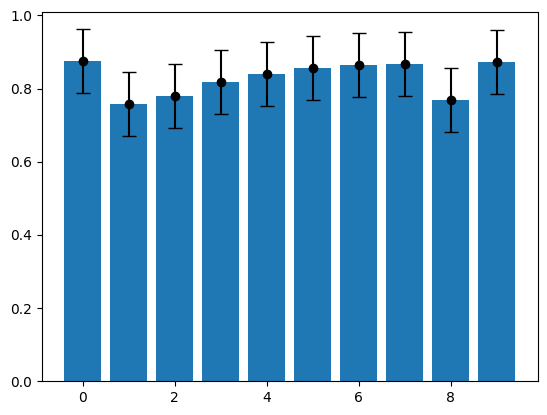

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa03d1ea140>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa03d1ea680>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa03d1e9fc0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa03d1eabc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa03d1eae60>],
 'means': []}

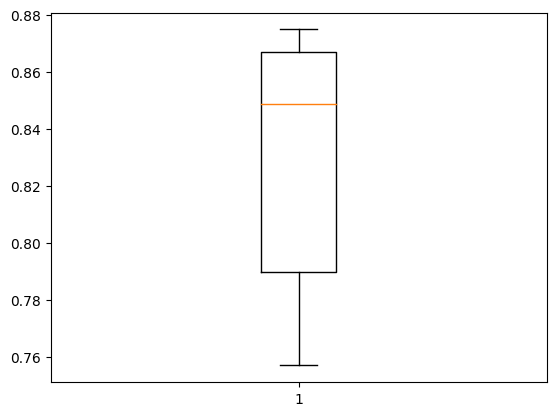

In [23]:
plt.bar(range(CV), cross_val["test_score"], label="test")
plt.errorbar(range(CV), cross_val["test_score"], yerr=2*cross_val["test_score"].std(), capsize=5, label="std",ecolor="black", fmt="o", barsabove=True, color="black")
plt.show()
plt.boxplot(cross_val["test_score"], vert=True)

---

### Grid Search

Cette fois, nous allons utiliser la validation croisée pour son utilisation habituelle : valider le choix d'hyperparamètres.

Nous allons utiliser la classe
[`model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) pour choisir le nombre de composante principale pour la PCA.

Cette classe permet de tester plusieurs paramètres (à entrer dans un dictionnaire) via la cross-validation (d'où le CV dans le nom).

Pour ce faire, nous n'avons plus besoin de nous occuper de créer différents subsets, la classe `GridSearchCV` s'en charge pour nous.

In [24]:
param_grid = {"pca__n_components": [1, 2, 5, 10, 20, 30, 40, 60]}

Nous allons utiliser un [`pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) pour réduire les dimensions via l'ACP et lancer ensuite l'apprentissage du modèle, ce qui va nous permettre de modifier les hyperparamètres (à potentiellement plusieures étapes de modélisation), d'entrainer différents modèles et de les évaluer en une seule commande.

Nous devrons utiliser les noms exacts des hyperparamètres à modifier dans le dictionnaire, précédés du nom du module et d'un double *underscore* (ici: `"pca__"`), pour pouvoir les assigner à la bonne étape du `pipeline`.

Définissez le [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

<span style="color:red">Implémentez votre solution ci-dessous</span>

In [25]:
pipe = pipeline.Pipeline(steps=[("pca", pca), ("gnb", gnb)])

Lancez le [Grid search avec cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

<span style="color:red">Implémentez votre solution ci-dessous</span>

In [26]:
grid_search = model_selection.GridSearchCV(pipe, param_grid, cv=CV, scoring=SCORING)

Trouvez le meilleur résultat, ainsi que la valeur de l'hyperparamètre correspondant.

<span style="color:red">Implémentez votre solution ci-dessous</span>

In [33]:
search = grid_search.fit(x_train, y_train)
best_params = search.best_params_
best_params

{'pca__n_components': 40}

Imprimez le tableau des résultats complets.

In [34]:
cv_results_df = pd.DataFrame(search.cv_results_).drop(columns="params")

cv_results_df.style.format("{:.2g}")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015,0.0057,0.0066,0.0044,1,0.32,0.29,0.33,0.27,0.36,0.34,0.4,0.35,0.31,0.4,0.34,0.041,8
1,0.0087,0.0019,0.0034,0.0012,2,0.6,0.59,0.65,0.6,0.62,0.61,0.68,0.61,0.57,0.66,0.62,0.031,7
2,0.016,0.0033,0.0038,0.0021,5,0.8,0.78,0.86,0.83,0.86,0.84,0.9,0.87,0.77,0.86,0.84,0.04,6
3,0.019,0.0078,0.0051,0.0029,10,0.91,0.9,0.9,0.89,0.9,0.91,0.93,0.92,0.9,0.94,0.91,0.017,4
4,0.013,0.0038,0.0038,0.0021,20,0.94,0.9,0.94,0.94,0.93,0.92,0.96,0.96,0.9,0.95,0.93,0.019,3
5,0.025,0.015,0.0062,0.0024,30,0.95,0.94,0.93,0.93,0.94,0.94,0.96,0.96,0.91,0.96,0.94,0.015,2
6,0.027,0.0025,0.0062,0.0027,40,0.94,0.94,0.93,0.93,0.94,0.93,0.97,0.98,0.92,0.96,0.94,0.019,1
7,0.01,0.00092,0.0032,0.00021,60,0.9,0.88,0.89,0.89,0.87,0.93,0.92,0.94,0.84,0.9,0.9,0.028,5


Faites un diagramme à barres avec les résultats moyens par valeur de l'hyperparamètre.

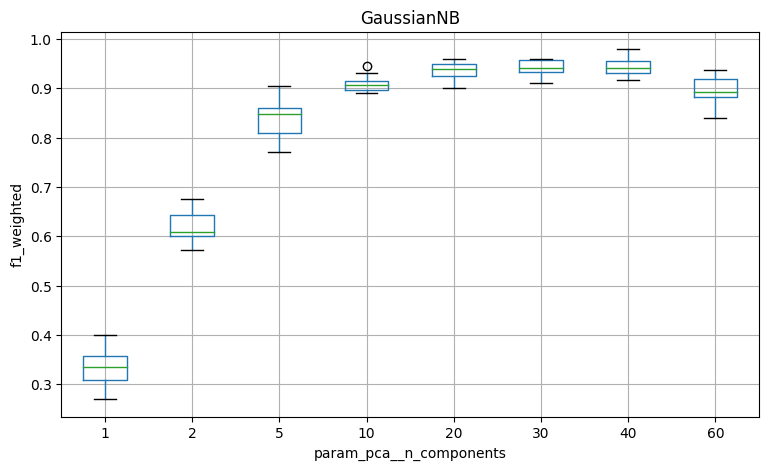

In [35]:
cv_score_cols = [f"split{i}_test_score" for i in range(CV)]
param = "pca__n_components"

cv_res_df = (
    cv_results_df[cv_score_cols]
    .set_index(cv_results_df[f"param_{param}"])
    .transpose()
)

cv_res_df.boxplot(figsize=(9, 5))
plt.title(gnb.__class__.__name__)
plt.ylabel(SCORING)
plt.xlabel(f"param_{param}")
# plt.savefig("img/boxplot-cv.pdf", bbox_inches="tight")
plt.show()

## Exercice (optionnel)

En utilisant la méthode `.predict_proba` de `linear_model.LogisticRegression`, utiliser le résultat de la prédiction pour sélectionner un seuil (*threshold*) particulier pour influencer la classification.

* Pouvez-vous obtenir 100 % de [précision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) ?
* Pouvez-vous obtenir 100 % de [rappel](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) ?
* Mesurez les valeurs de [f1-scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) et commentez.
* Tracez la [ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) à partir de plusieurs valeurs de seuil.
* Comparez les [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) (aire sous la courbe ROC) de la `linear_model.LogisticRegression` et de `naive_bayes.GaussianNB()`.

---